In [1]:
import os

HOME = os.getcwd()
print(HOME)

/kaggle/working


## Install YOLO11 via Ultralytics

In [2]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6170.1/8062.4 GB disk)


In [3]:
from ultralytics import YOLO

from IPython.display import display, Image
import optuna
from ultralytics import YOLO
# from ray.tune.integration.optuna import OptunaSearch
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import torch
import torch.nn as nn
import torch.nn.functional as F

## Dataset Loading

In [4]:
# Set up directory paths
# !mkdir {HOME}/datasets
%cd {HOME}/datasets

/kaggle/working/datasets


In [5]:
%ls ./runs/segment

train/    train17/  train24/  train31/  train39/  train46/  train53/  train60/
train10/  train18/  train25/  train32/  train4/   train47/  train54/  train61/
train11/  train19/  train26/  train33/  train40/  train48/  train55/  train7/
train12/  train2/   train27/  train34/  train41/  train49/  train56/  train8/
train13/  train20/  train28/  train35/  train42/  train5/   train57/  train9/
train14/  train21/  train29/  train36/  train43/  train50/  train58/
train15/  train22/  train3/   train37/  train44/  train51/  train59/
train16/  train23/  train30/  train38/  train45/  train52/  train6/


In [6]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="Sn1vSUk86V5QpQ25WfdA")
# project = rf.workspace("mohamed-traore-2ekkp").project("taco-trash-annotations-in-context")
# version = project.version(15)
# dataset = version.download("yolov11")
# https://universe.roboflow.com/taco-9911u/taco-trash-annotations-in-context-bumvw/dataset/5

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Sn1vSUk86V5QpQ25WfdA")
project = rf.workspace("taco-9911u").project("taco-trash-annotations-in-context-bumvw")
version = project.version(10)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [7]:
# !pip install roboflow

# from roboflow import Roboflow
# rf2 = Roboflow(api_key="Sn1vSUk86V5QpQ25WfdA")
# project2 = rf2.workspace("taco-9911u").project("taco-trash-annotations-in-context-nlbac")
# version2 = project2.version(8)
# dataset2 = version2.download("yolov11")

## Model Training

In [8]:
def search_by_extension(directory, extension):
    """
    Search for files with a specific extension in a directory.

    Parameters:
    directory (str): The directory to search.
    extension (str): The file extension (e.g., ".txt").

    Returns:
    list: A list of paths to files with the given extension.
    """
    matches = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                matches.append(os.path.join(root, file))
    return matches

# Example usage
results = search_by_extension("../..", ".pt")
print("Python files found:", results)

Python files found: ['../../input/taco_model/pytorch/default/1/best_v10_56p1.pt', '../../working/yolo11n.pt', '../../working/runs/segment/train58/weights/best.pt', '../../working/runs/segment/train58/weights/last.pt', '../../working/runs/segment/train6132/weights/best.pt', '../../working/runs/segment/train6132/weights/last.pt', '../../working/runs/segment/train61322/weights/best.pt', '../../working/runs/segment/train61322/weights/last.pt', '../../working/runs/segment/train61/weights/best.pt', '../../working/runs/segment/train61/weights/last.pt', '../../working/runs/segment/train613/weights/best.pt', '../../working/runs/segment/train613/weights/last.pt', '../../working/runs/segment/train57/weights/best.pt', '../../working/runs/segment/train57/weights/last.pt', '../../working/runs/segment/train613222/weights/best.pt', '../../working/runs/segment/train613222/weights/last.pt', '../../working/datasets/yolo11n.pt', '../../working/datasets/runs/segment/train22/weights/best.pt', '../../working

In [9]:
%ls ../../input/taco_model/pytorch/default/1

best_v10_56p1.pt


In [10]:
# Define Dice Loss
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = preds.sigmoid()  # Convert logits to probabilities
        intersection = (preds * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice_coeff  # Dice loss is 1 - Dice coefficient

# Define Focal Loss with suggested gamma
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(preds, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Probability of correct classification
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

# Define Hybrid Loss (Dice + Focal)
class DiceFocalLoss(torch.nn.Module):
    def __init__(self):
        super(DiceFocalLoss, self).__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss(gamma=1.6)

    def forward(self, preds, targets):
        return self.dice(preds, targets) + self.focal(preds, targets)

In [11]:
!dir runs/segment/train41/weights

best.pt  last.pt


In [12]:
model = YOLO("runs/segment/train41/weights/last.pt")
# model = YOLO("runs/segment/train43/weights/last.pt")
# Set the data path
data_path = f'{dataset.location}/data.yaml'  # Replace with actual path

# Apply custom loss
model.loss = DiceFocalLoss()

In [13]:
# Define the objective function
gen = (i for i in range(10))
def objective(trial):
    # Suggest hyperparameters
    lr0 = trial.suggest_float("lr0", .0001, .0002,step=.00002)  
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)  
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 5e-4, step=1e-4)

    # Train the model with suggested hyperparameters
    results = model.train(
        data=data_path,
        epochs=30,
        imgsz=736,
        batch=8,  
        lr0=lr0,    
        plots=True,
        patience=15,
        dropout=dropout,  
        optimizer='SGD',
        weight_decay=weight_decay,  
        cos_lr=True,    
        warmup_epochs=3,
        save_dir="runs/segment/taco_train"
    )

In [ ]:
# Optuna optimization set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2025-03-12 14:10:37,594] A new study created in memory with name: no-name-0df59643-3b29-4724-b314-df039aac9507


New https://pypi.org/project/ultralytics/8.3.88 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=runs/segment/train41/weights/last.pt, data=/kaggle/working/datasets/TACO:-Trash-Annotations-in-Context-Dataset-10/data.yaml, epochs=30, time=None, patience=15, batch=8, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train62, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.4, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False,

100%|██████████| 755k/755k [00:00<00:00, 25.0MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768

train: Scanning /kaggle/working/datasets/TACO:-Trash-Annotations-in-Context-Dataset-10/train/labels.cache... 3057 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3057/3057 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.5 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/datasets/TACO:-Trash-Annotations-in-Context-Dataset-10/valid/labels.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


Plotting labels to runs/segment/train62/labels.jpg... 
optimizer: SGD(lr=0.0002, momentum=0.937) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0001), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 4 dataloader workers
Logging results to runs/segment/train62
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      15.2G     0.6037     0.8917     0.5377     0.9677          3        736: 100%|██████████| 383/383 [09:11<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        110        164       0.53      0.562      0.601      0.541      0.524      0.555      0.588      0.518



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30      15.1G     0.6132     0.9063     0.5348     0.9706          5        736: 100%|██████████| 383/383 [09:05<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.744      0.494      0.624      0.564      0.744      0.494      0.615      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30      15.2G     0.6171     0.8951     0.5575     0.9768          1        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        110        164      0.635      0.558      0.609      0.548      0.635      0.558      0.601      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30      14.9G      0.611     0.8924     0.5375     0.9656          2        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.603      0.516      0.563      0.501      0.598      0.513      0.548      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30      15.1G     0.6083      0.889     0.5436     0.9708          2        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.552      0.632      0.624       0.56       0.69      0.515      0.615      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30      15.1G     0.6033     0.8734     0.5232     0.9636          4        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.571      0.626      0.614      0.553      0.554      0.613      0.605      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30      15.1G     0.6061     0.8728     0.5278     0.9636          2        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.555      0.609      0.592      0.535      0.545      0.597      0.579      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30      15.1G     0.5987     0.8723     0.5262     0.9589          1        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164      0.663       0.47      0.571      0.513      0.671      0.469      0.562      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30      15.2G      0.595     0.8713     0.5184     0.9599          1        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164      0.537      0.568      0.592      0.528      0.568      0.538      0.578      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30      15.1G     0.5984     0.8546     0.5158     0.9595          0        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.712      0.487      0.583      0.523      0.719      0.484      0.576      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30      15.1G     0.5849     0.8571     0.5029     0.9512          2        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        110        164      0.672      0.515       0.57      0.519      0.657      0.528      0.567      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30        15G     0.5945     0.8739      0.507     0.9554         11        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.708      0.466      0.591      0.533      0.708      0.458      0.582      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30      15.1G     0.6039     0.8868     0.5183     0.9602          1        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164      0.713      0.482      0.565      0.511      0.725      0.472      0.555      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30      15.1G     0.5972      0.875     0.5041     0.9657          2        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.639       0.54      0.572      0.524      0.638      0.541      0.566      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30      15.1G     0.5905     0.8606     0.5077      0.962          4        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164      0.604      0.551      0.579      0.523        0.6      0.551      0.573       0.51



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30      15.2G     0.5839     0.8478     0.4982     0.9557          1        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164       0.73      0.499      0.597      0.539      0.727      0.499      0.584       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30      15.2G     0.5896     0.8658     0.4983     0.9553          2        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        110        164      0.708      0.501      0.566      0.516      0.703      0.501       0.56      0.494
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 2, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



17 epochs completed in 2.610 hours.
Optimizer stripped from runs/segment/train62/weights/last.pt, 124.8MB
Optimizer stripped from runs/segment/train62/weights/best.pt, 124.8MB

Validating runs/segment/train62/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x-seg summary (fused): 491 layers, 62,026,383 parameters, 0 gradients, 318.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


                   all        110        164      0.743      0.494      0.624      0.564      0.743      0.494      0.615      0.541
  Clear plastic bottle         21         28       0.88      0.714      0.854      0.743       0.88      0.714      0.854      0.694
     Corrugated carton          5          7       0.66      0.286      0.545      0.507       0.66      0.286      0.405      0.387
          Crisp packet          4          4      0.426       0.25      0.377      0.377      0.426       0.25      0.377      0.377
Disposable food container          4          4          0          0      0.017      0.017          0          0      0.017      0.017
Disposable plastic cup         12         13       0.44      0.231       0.34      0.311       0.44      0.231       0.34      0.205
            Egg carton          2          2      0.799        0.5      0.507      0.507      0.799        0.5      0.507      0.456
              Foam cup          2          2      0.732        0.5

[W 2025-03-12 16:47:53,193] Trial 0 failed with parameters: {'lr0': 0.0002, 'dropout': 0.4, 'weight_decay': 0.0001} because of the following error: The value None could not be cast to float..
[W 2025-03-12 16:47:53,194] Trial 0 failed with value None.


New https://pypi.org/project/ultralytics/8.3.88 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=runs/segment/train41/weights/last.pt, data=/kaggle/working/datasets/TACO:-Trash-Annotations-in-Context-Dataset-10/data.yaml, epochs=30, time=None, patience=15, batch=8, imgsz=736, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train622, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False

train: Scanning /kaggle/working/datasets/TACO:-Trash-Annotations-in-Context-Dataset-10/train/labels.cache... 3057 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3057/3057 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/datasets/TACO:-Trash-Annotations-in-Context-Dataset-10/valid/labels.cache... 110 images, 0 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<?, ?it/s]


Plotting labels to runs/segment/train622/labels.jpg... 
optimizer: SGD(lr=0.00016, momentum=0.937) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0001), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 4 dataloader workers
Logging results to runs/segment/train622
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      15.2G     0.5758     0.8503     0.5002     0.9557          3        736: 100%|██████████| 383/383 [09:10<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.716      0.503      0.605      0.546      0.716      0.503      0.597      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30      15.1G     0.5658     0.8413       0.48     0.9505          5        736: 100%|██████████| 383/383 [09:05<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.675      0.524      0.627      0.569      0.675      0.524      0.621      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30      15.2G      0.616     0.8944     0.5465     0.9758          1        736: 100%|██████████| 383/383 [09:04<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        110        164      0.708      0.533      0.632       0.57      0.708      0.533      0.625      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30      14.9G     0.6058     0.8879     0.5267     0.9638          2        736: 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        110        164      0.701      0.492       0.58      0.525      0.701      0.492       0.57      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30      14.9G     0.5931     0.8587     0.5286     0.9708         16        736:  43%|████▎     | 166/383 [03:56<05:08,  1.42s/it]

In [6]:
!cd {HOME}

# Define YOLO training parameters and execute it
#!yolo task=segment mode=train model=yolov8x-seg.pt data={dataset.location}/data.yaml epochs=105 imgsz=544 dropout=0.2 optimizer=SGD patience=50
# !yolo task=segment mode=train model=yolo11x-seg.pt data={dataset.location}/data.yaml epochs=300 imgsz=544 lr0=0.001 dropout=0.3 plots=True patience=50 optimizer=SGD
!yolo task=segment mode=train model=/kaggle/input/taco_model/pytorch/default/1/best_v10_56p1.pt data={dataset.location}/data.yaml epochs=50 imgsz=608 lr0=lr=0.00016 dropout=0.62 plots=True optimizer=SGD
# !yolo task=segment mode=train model={model} data={dataset.location}/data.yaml epochs=300 imgsz=544 lr0=0.001 dropout=0.1 plots=True patience=50 optimizer=SGD

/bin/bash: line 1: cd: {HOME}: No such file or directory


### List files in the specified directory


In [1]:
!ls {HOME}/runs/segment

ls: cannot access '{HOME}/runs/segment': No such file or directory


# Model Evaluation
## Confusion Matrix

In [7]:
%ls ../lib/kaggle

gcp.py


In [9]:
%ls . 


datasets/


In [10]:
%ls ./runs/segment

ls: cannot access './runs/segment': No such file or directory


In [13]:
 %ls ./runs/segment

train57/  train61/   train613/   train61322/
train58/  train612/  train6132/  train613222/


/kaggle/working


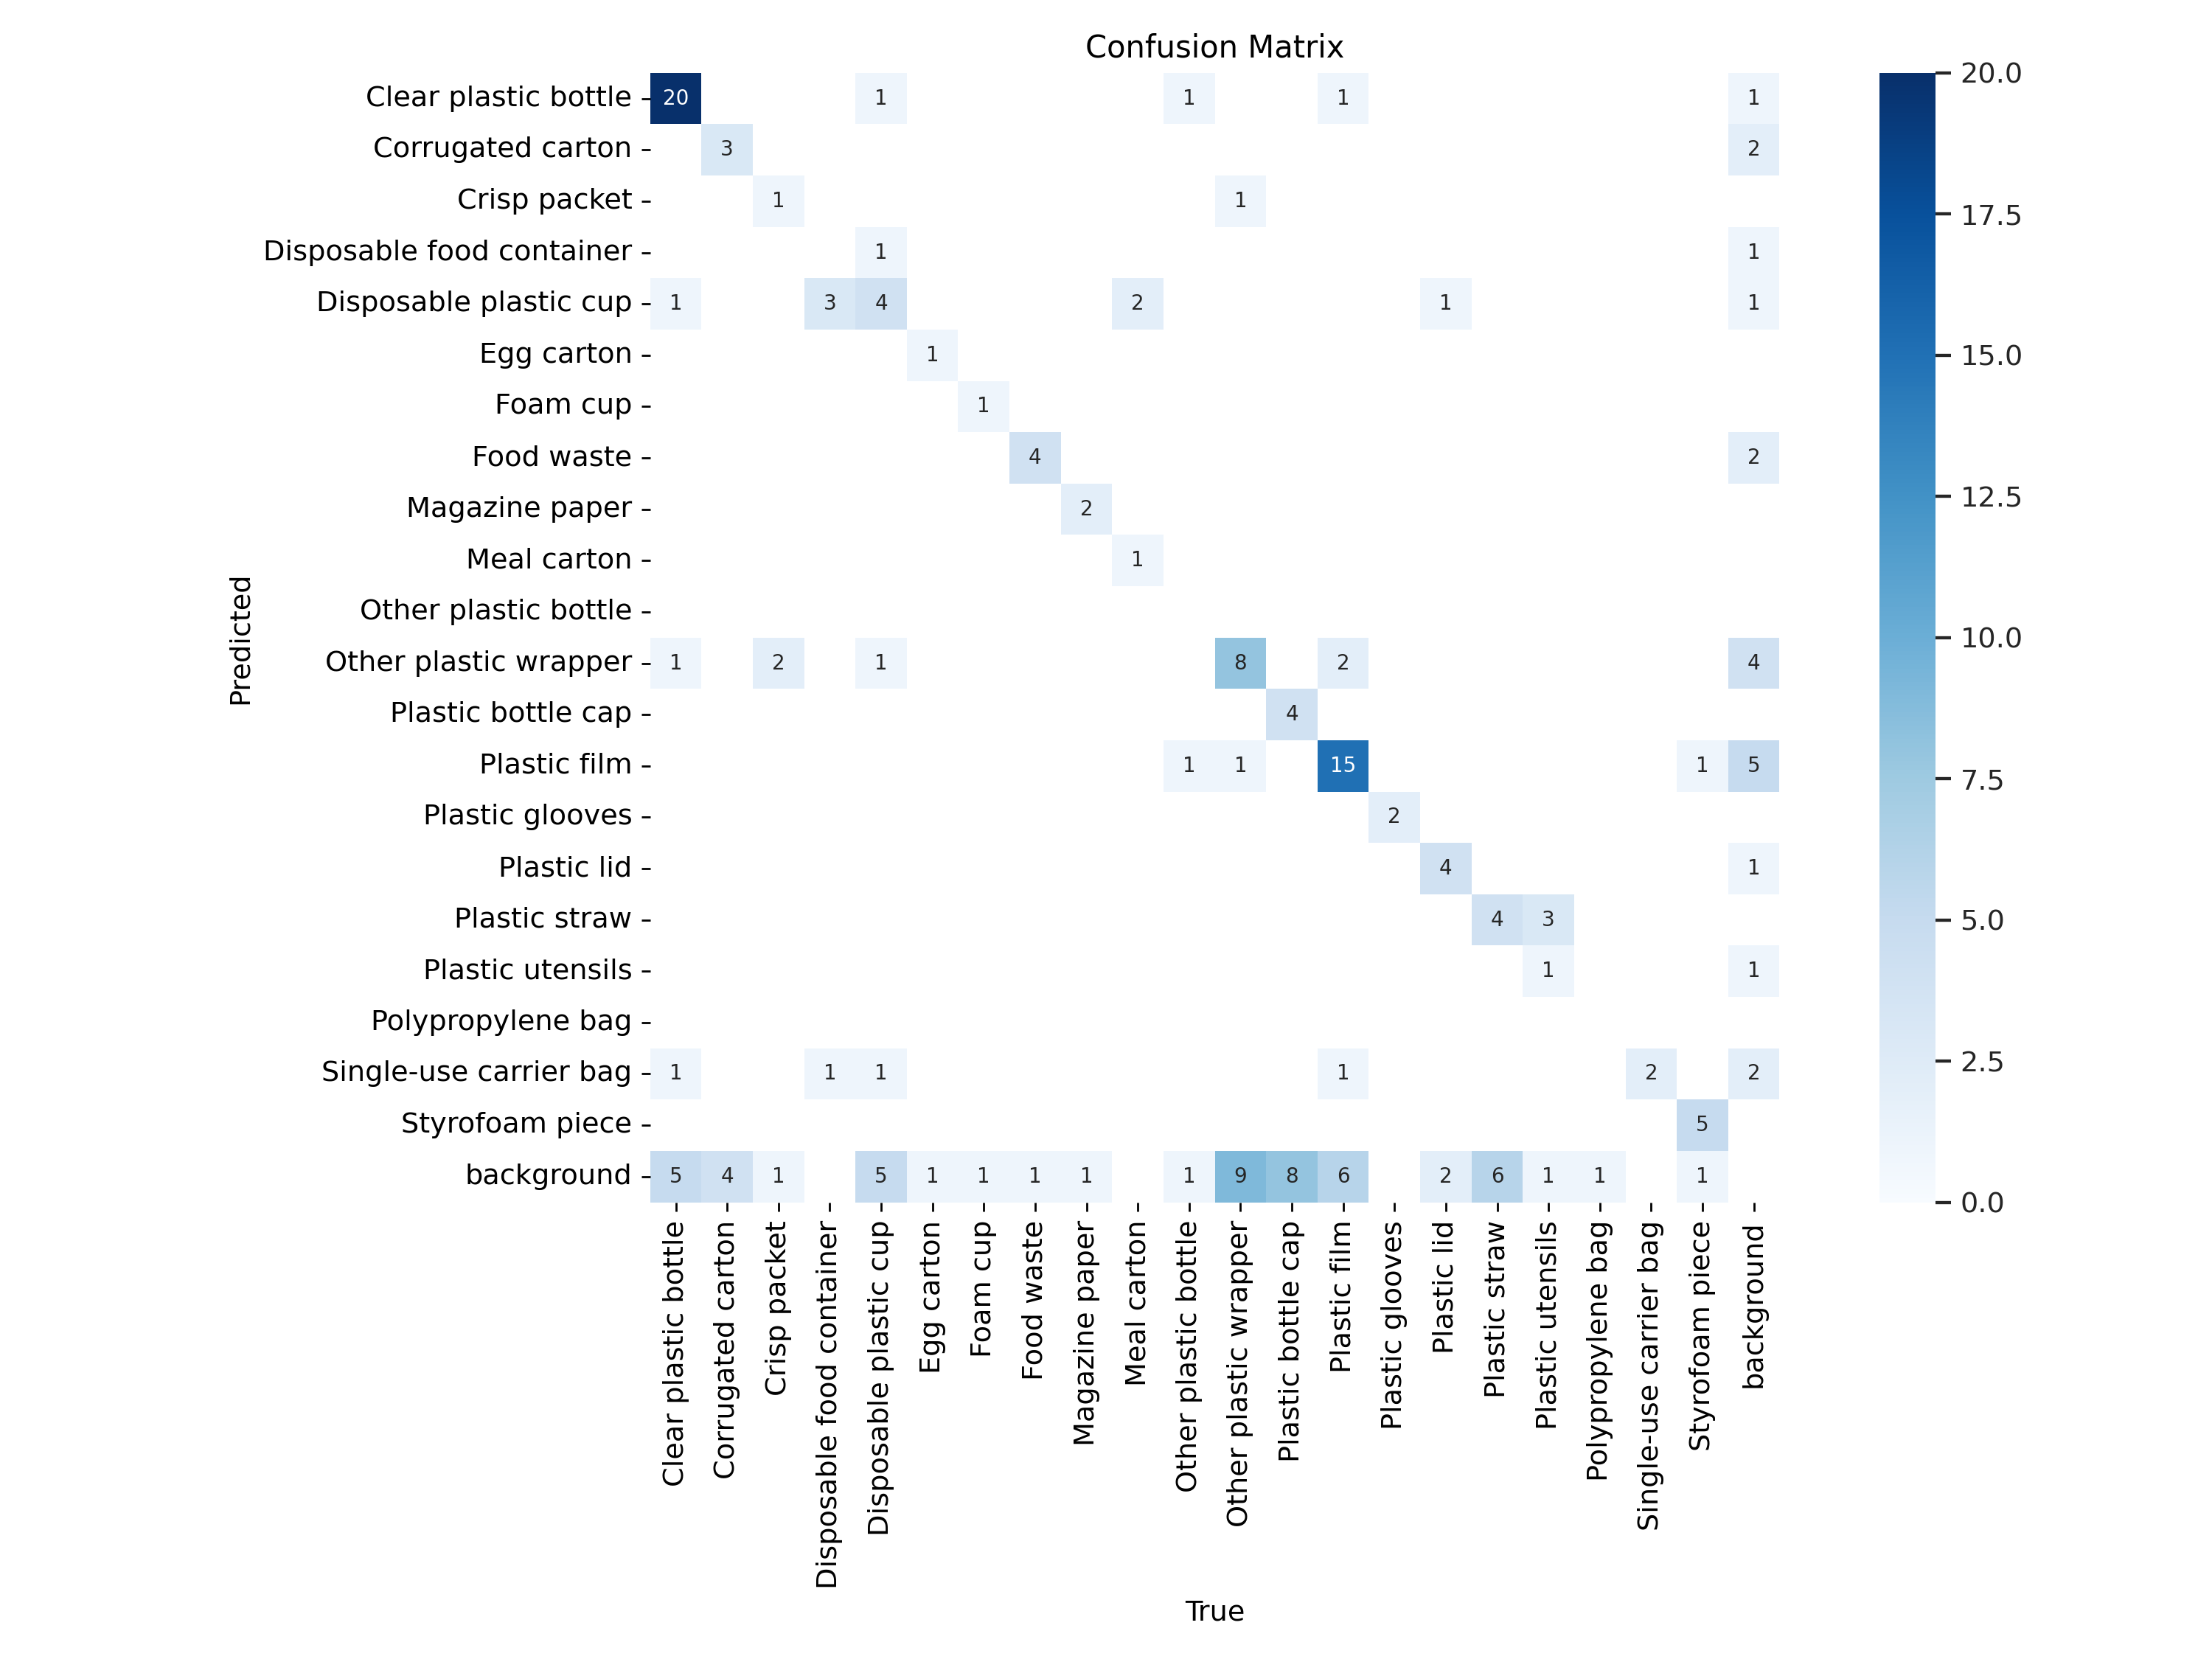

In [14]:
%cd {HOME}
# runs/segment/train/weights/best.pt
Image(filename=f'{HOME}/runs/segment/train61322/confusion_matrix.png', width=800)


## Metrics

- The box loss, often referred to as localization loss or regression loss, measures how well the model predicts the bounding box coordinates (x, y, width, height) for each object in the image.
- The segmentation loss measures the difference between the predicted segmentation mask and the ground truth mask for each object.
- The classification loss, often simply called the class loss, measures how well the model classifies the objects within the predicted bounding boxes
- mAP50 (mean Average Precision at 50 IoU threshold) is a metric that combines precision and recall to assess the performance of a classification or object detection algorithm.



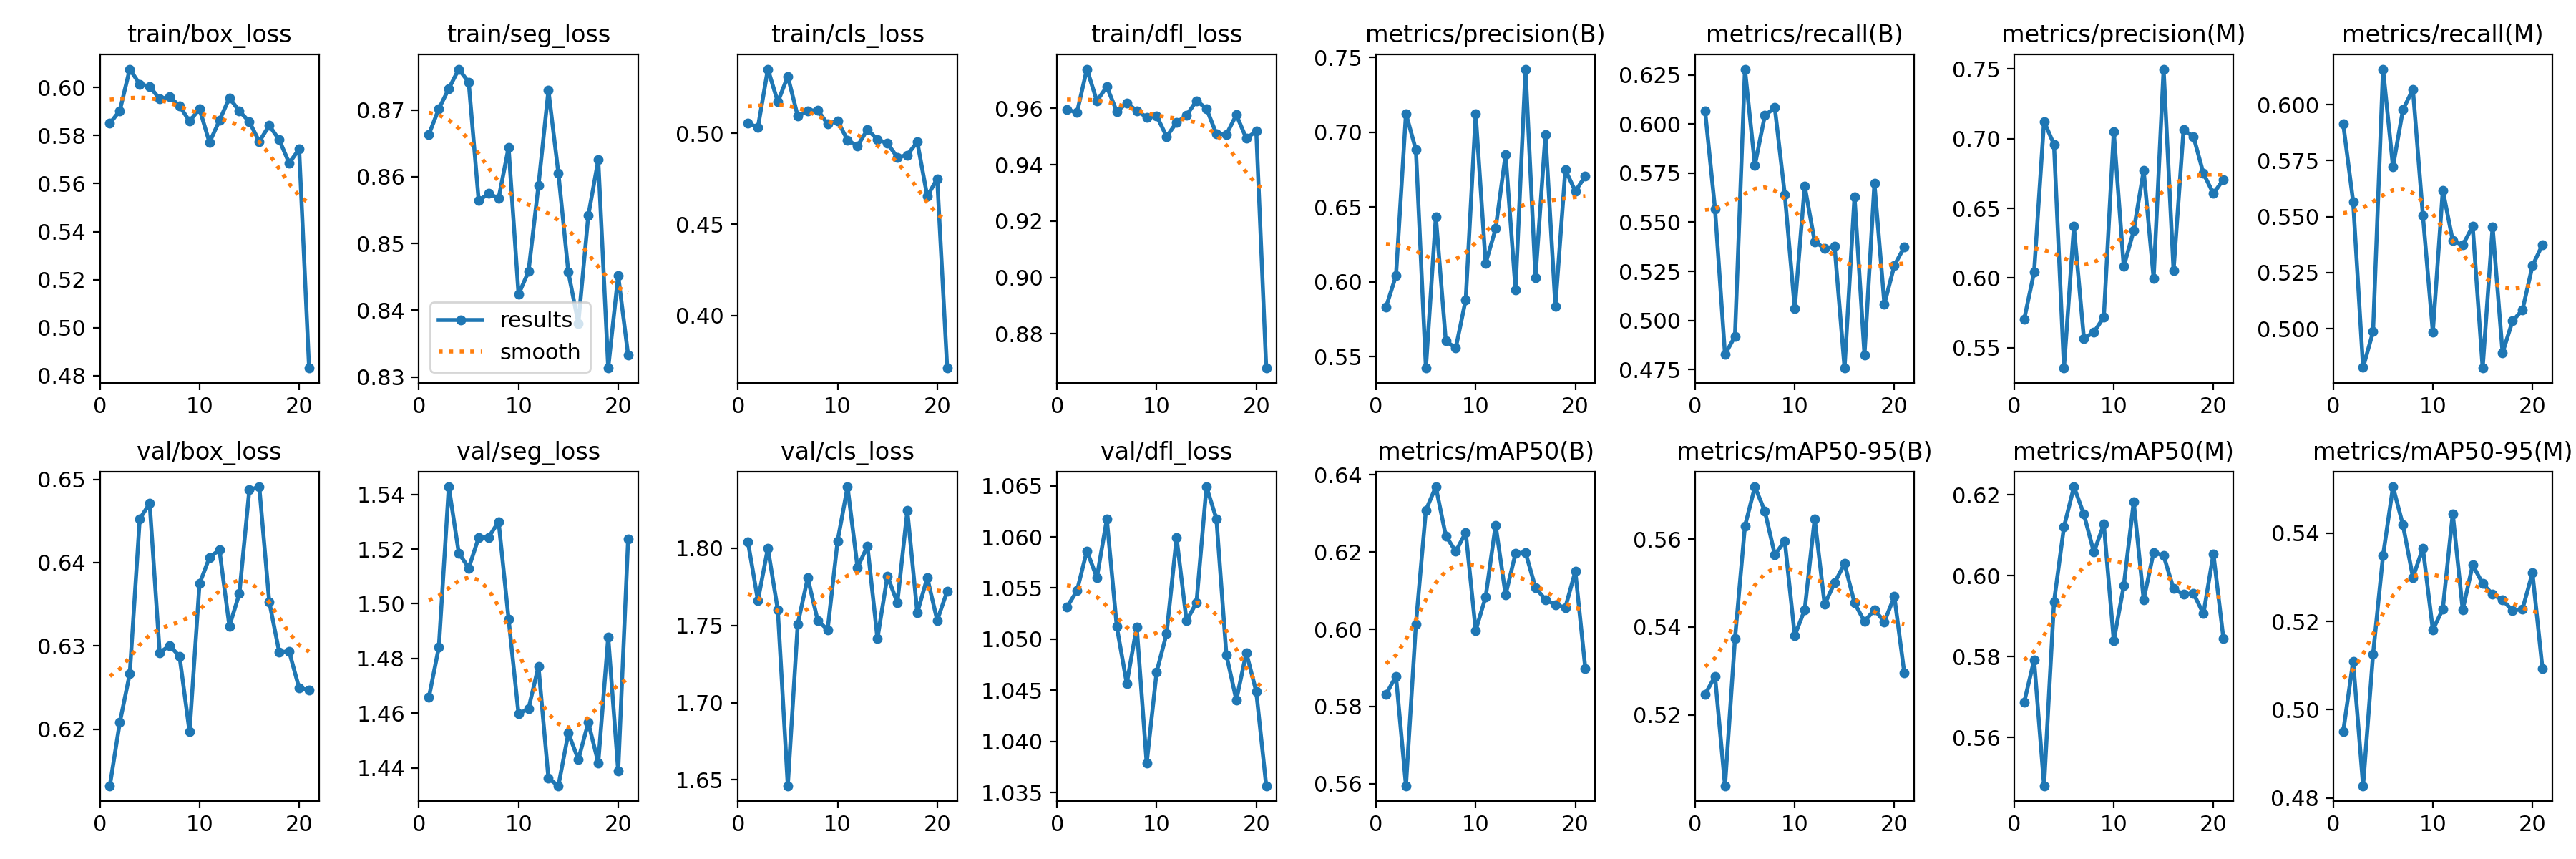

In [19]:
Image(filename=f'{HOME}/runs/segment/train613/results.png', width=1400)

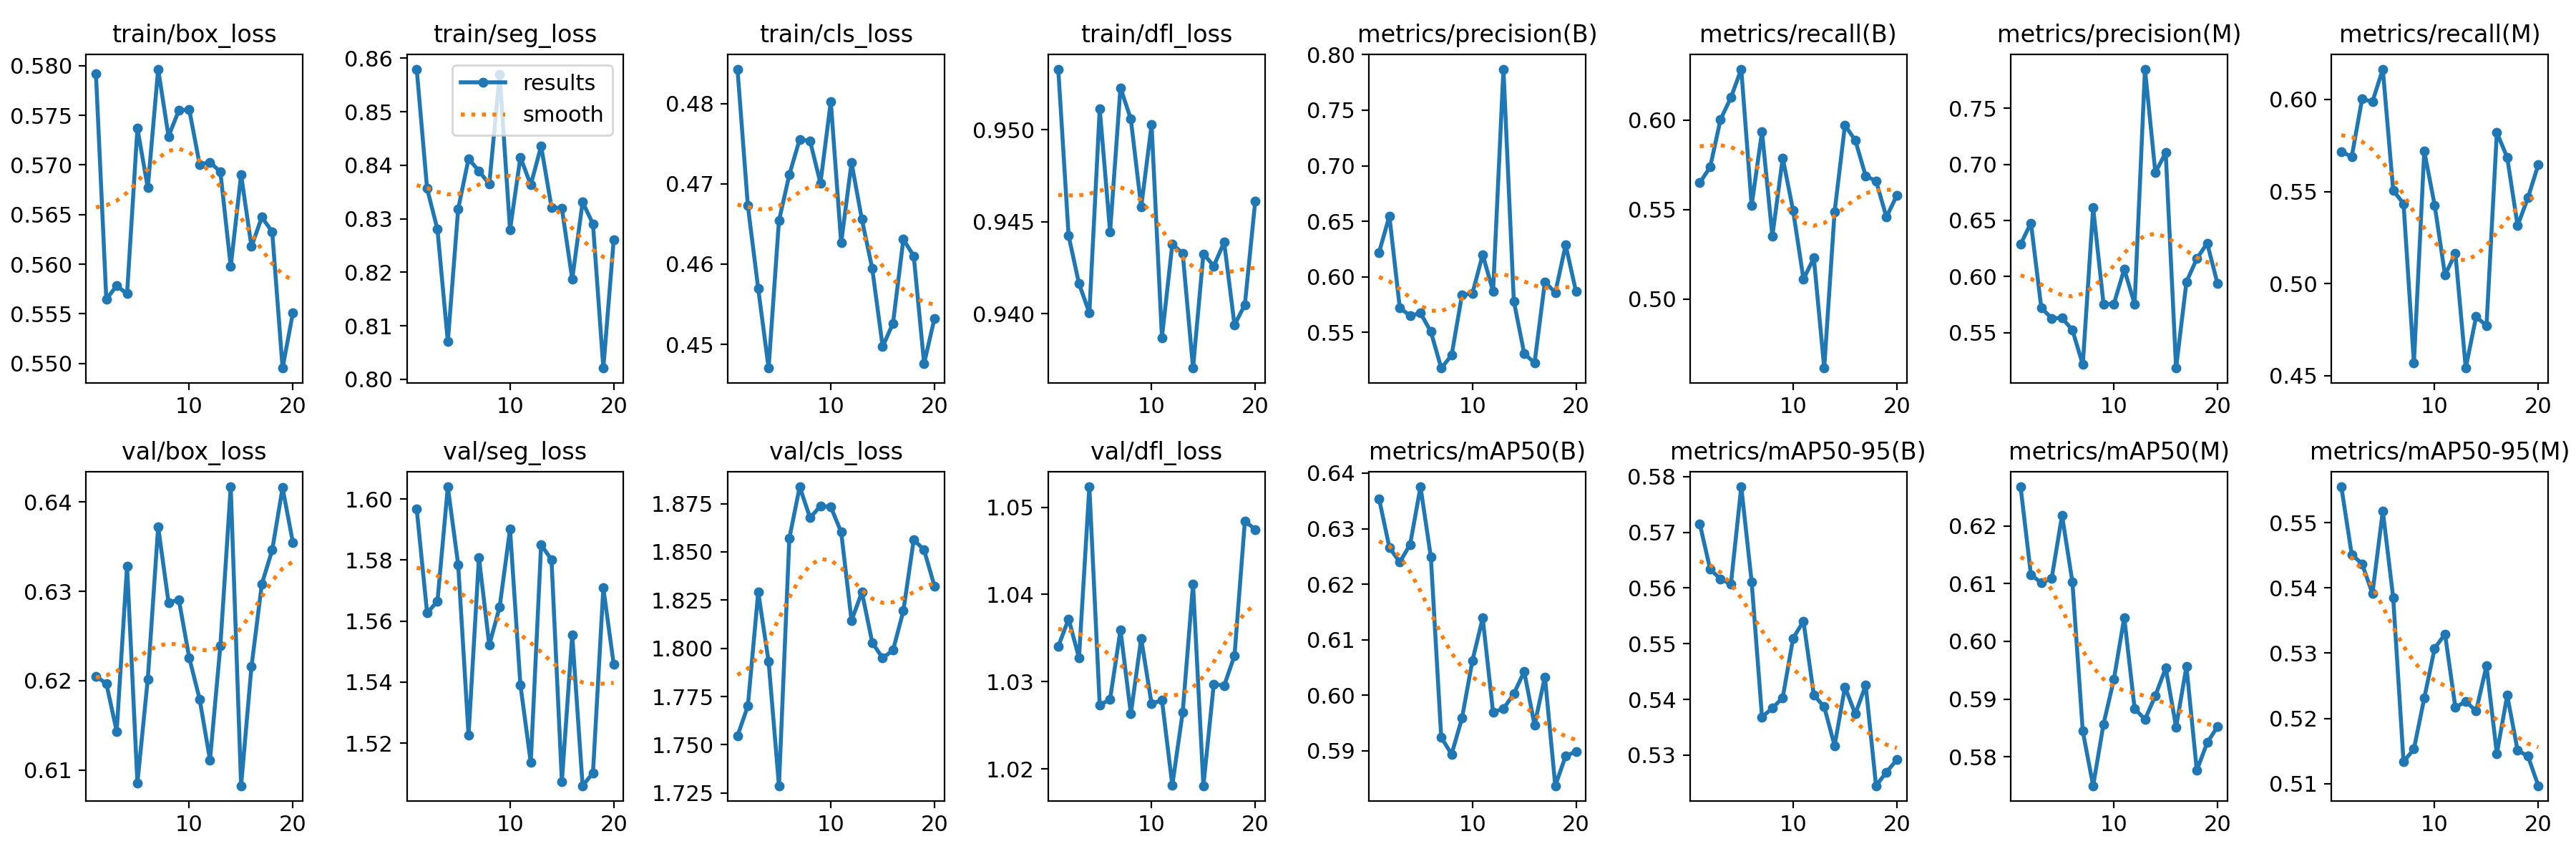

In [20]:
Image(filename=f'{HOME}/runs/segment/train6132/results.png', width=1400)

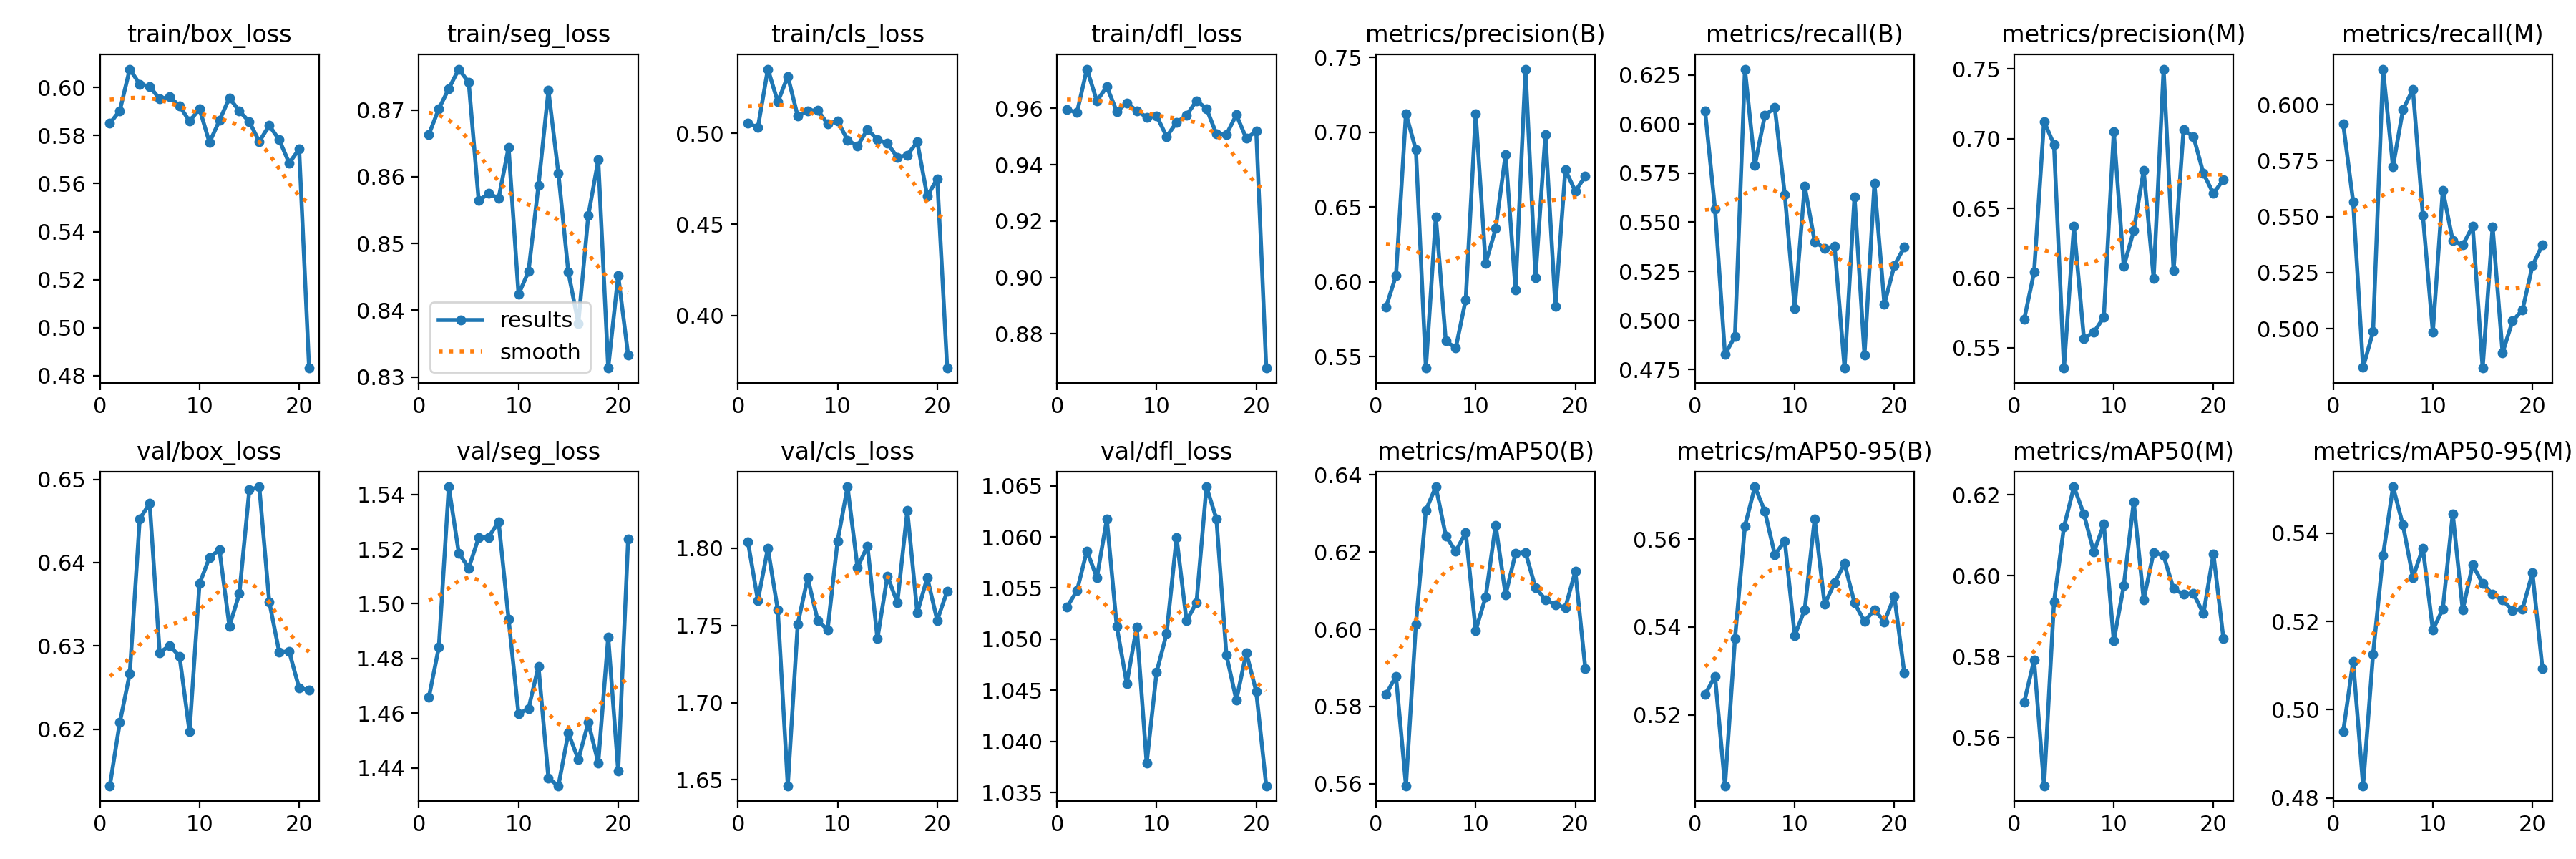

In [18]:
Image(filename=f'{HOME}/runs/segment/train61322/results.png', width=1400)

## Other Metrics

In [8]:
%ls ./datasets/runs/segment/train57

args.yaml                                         MaskR_curve.png
BoxF1_curve.png                                   results.csv
BoxP_curve.png                                    results.png
BoxPR_curve.png                                   train_batch0.jpg
BoxR_curve.png                                    train_batch1.jpg
confusion_matrix_normalized.png                   train_batch2.jpg
confusion_matrix.png                              val_batch0_labels.jpg
events.out.tfevents.1734808385.1aac27d513ef.40.4  val_batch0_pred.jpg
labels_correlogram.jpg                            val_batch1_labels.jpg
labels.jpg                                        val_batch1_pred.jpg
MaskF1_curve.png                                  val_batch2_labels.jpg
MaskP_curve.png                                   val_batch2_pred.jpg
MaskPR_curve.png                                  weights/


In [25]:
image_paths

[]

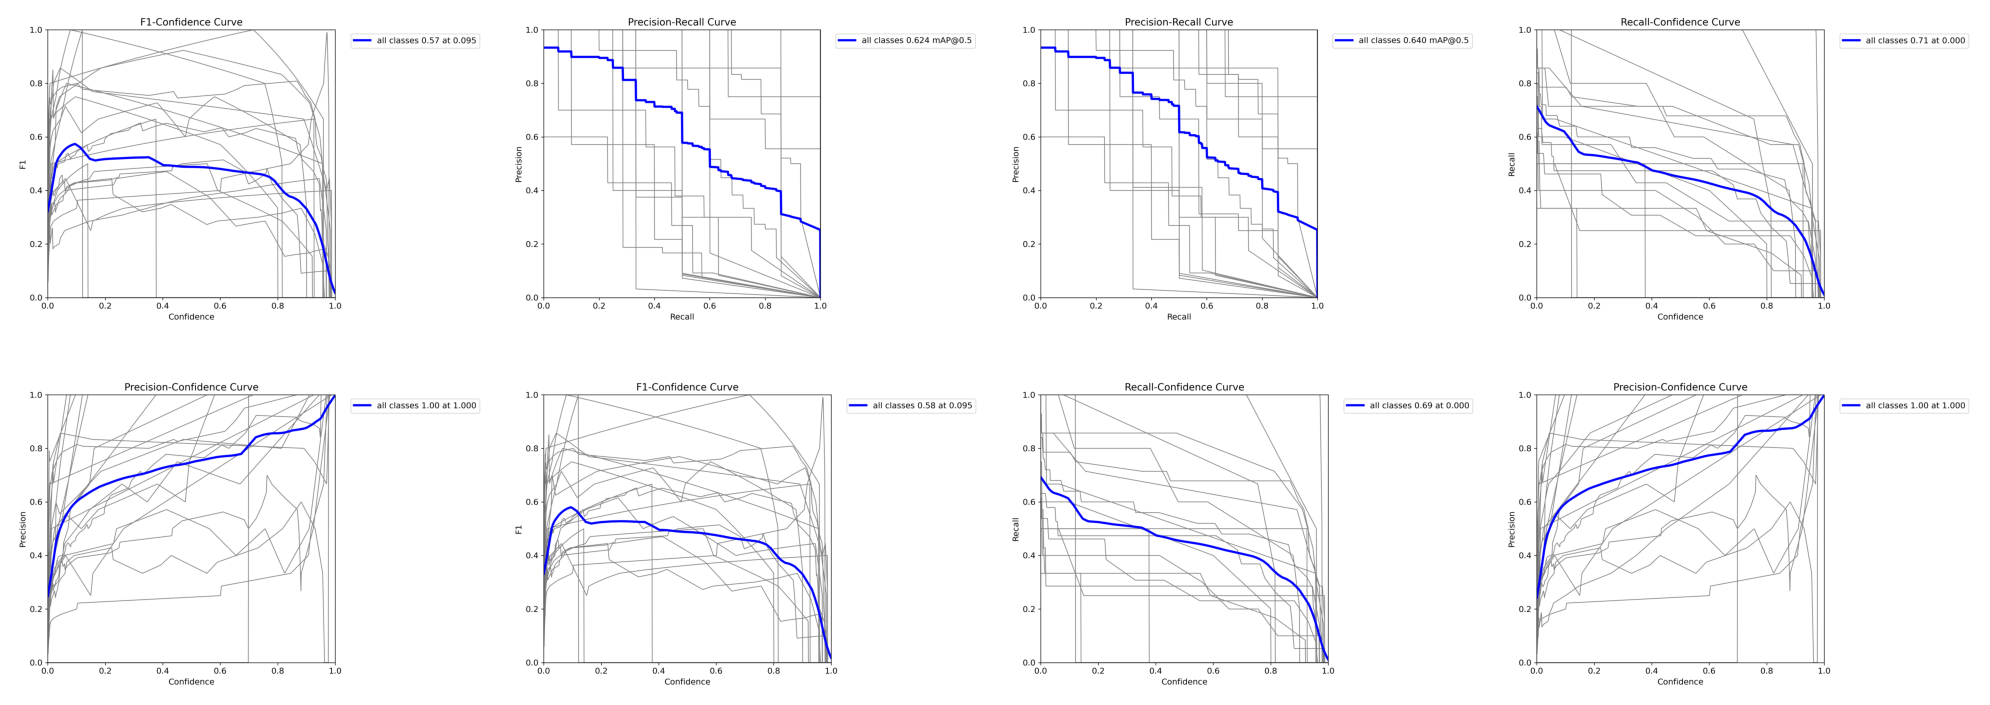

In [31]:
import glob
import matplotlib.pyplot as plt
import os

# Get all image paths
image_paths = glob.glob(f'{HOME}/runs/segment/train61322/*curve.png')

# Define number of columns
cols = 4
rows = (len(image_paths) + cols - 1) // cols  # Calculate rows dynamically

# Create figure
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * cols))  # Adjust figure size

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through images and display them
for i, image_path in enumerate(image_paths):
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis("off")  # Hide axes

# Hide any unused subplots
for i in range(len(image_paths), len(axes)):
    axes[i].axis("off")

# Show the plot
plt.tight_layout()
plt.show()


## Predictions

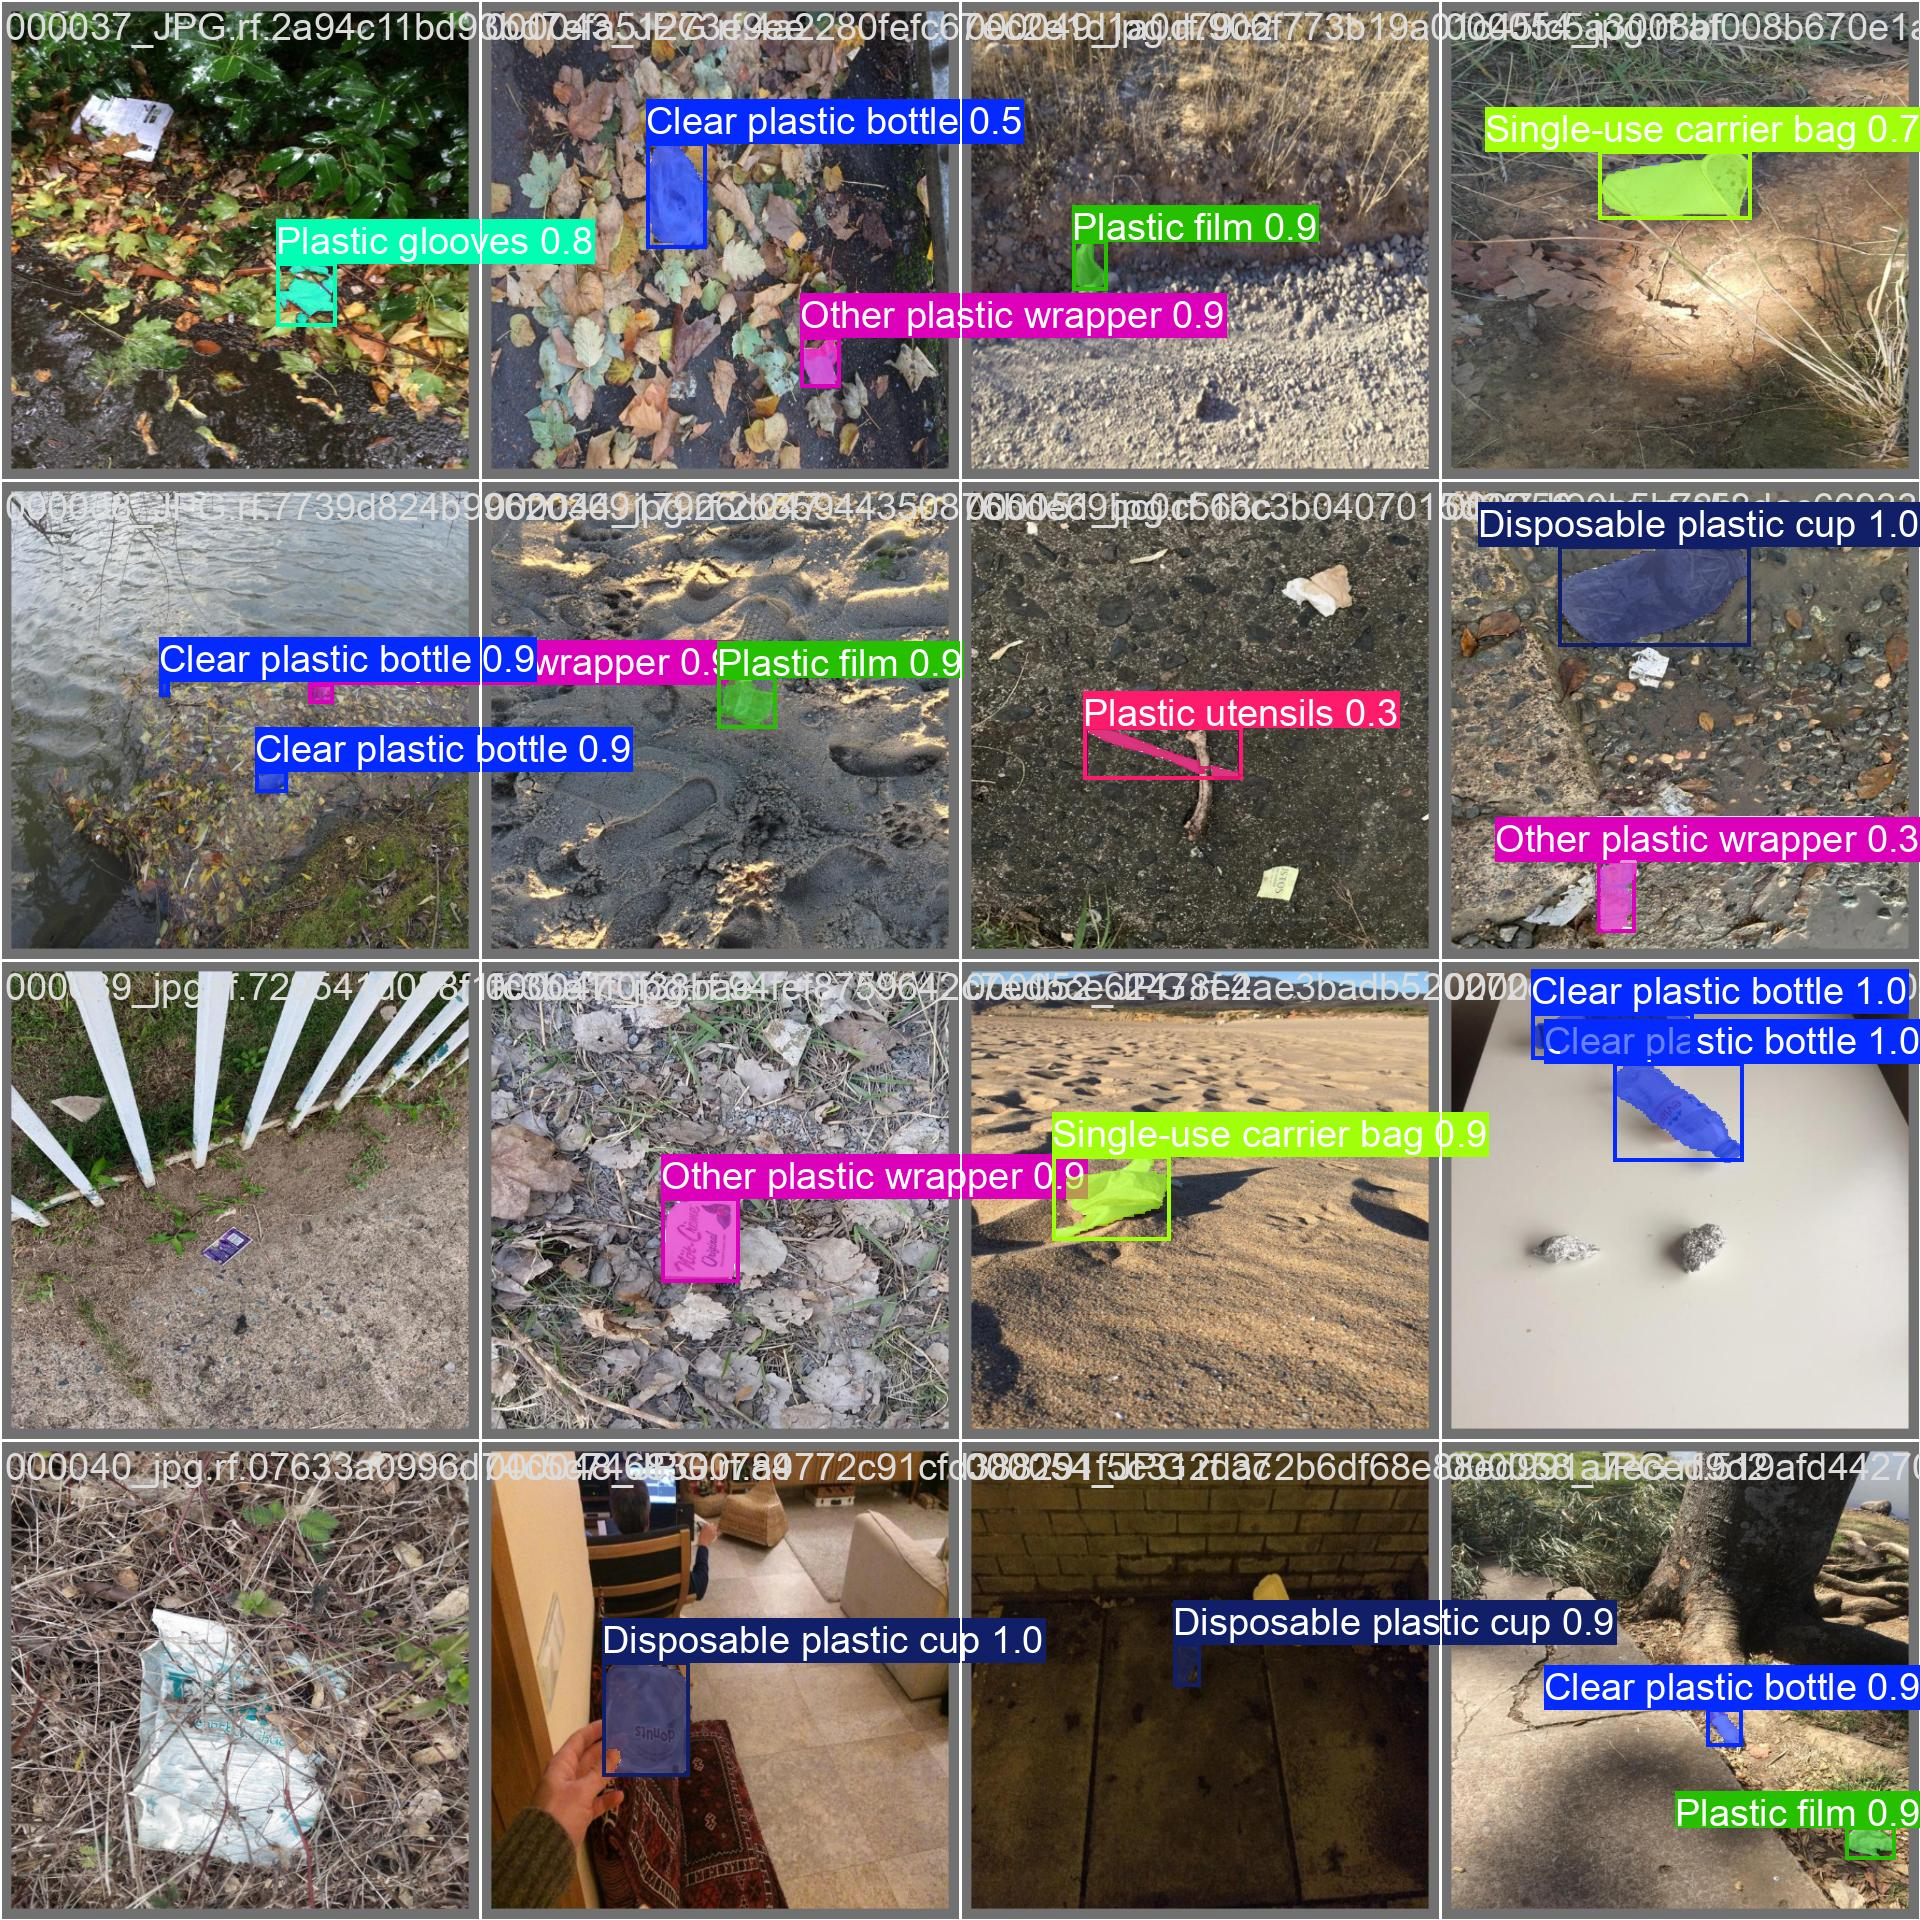

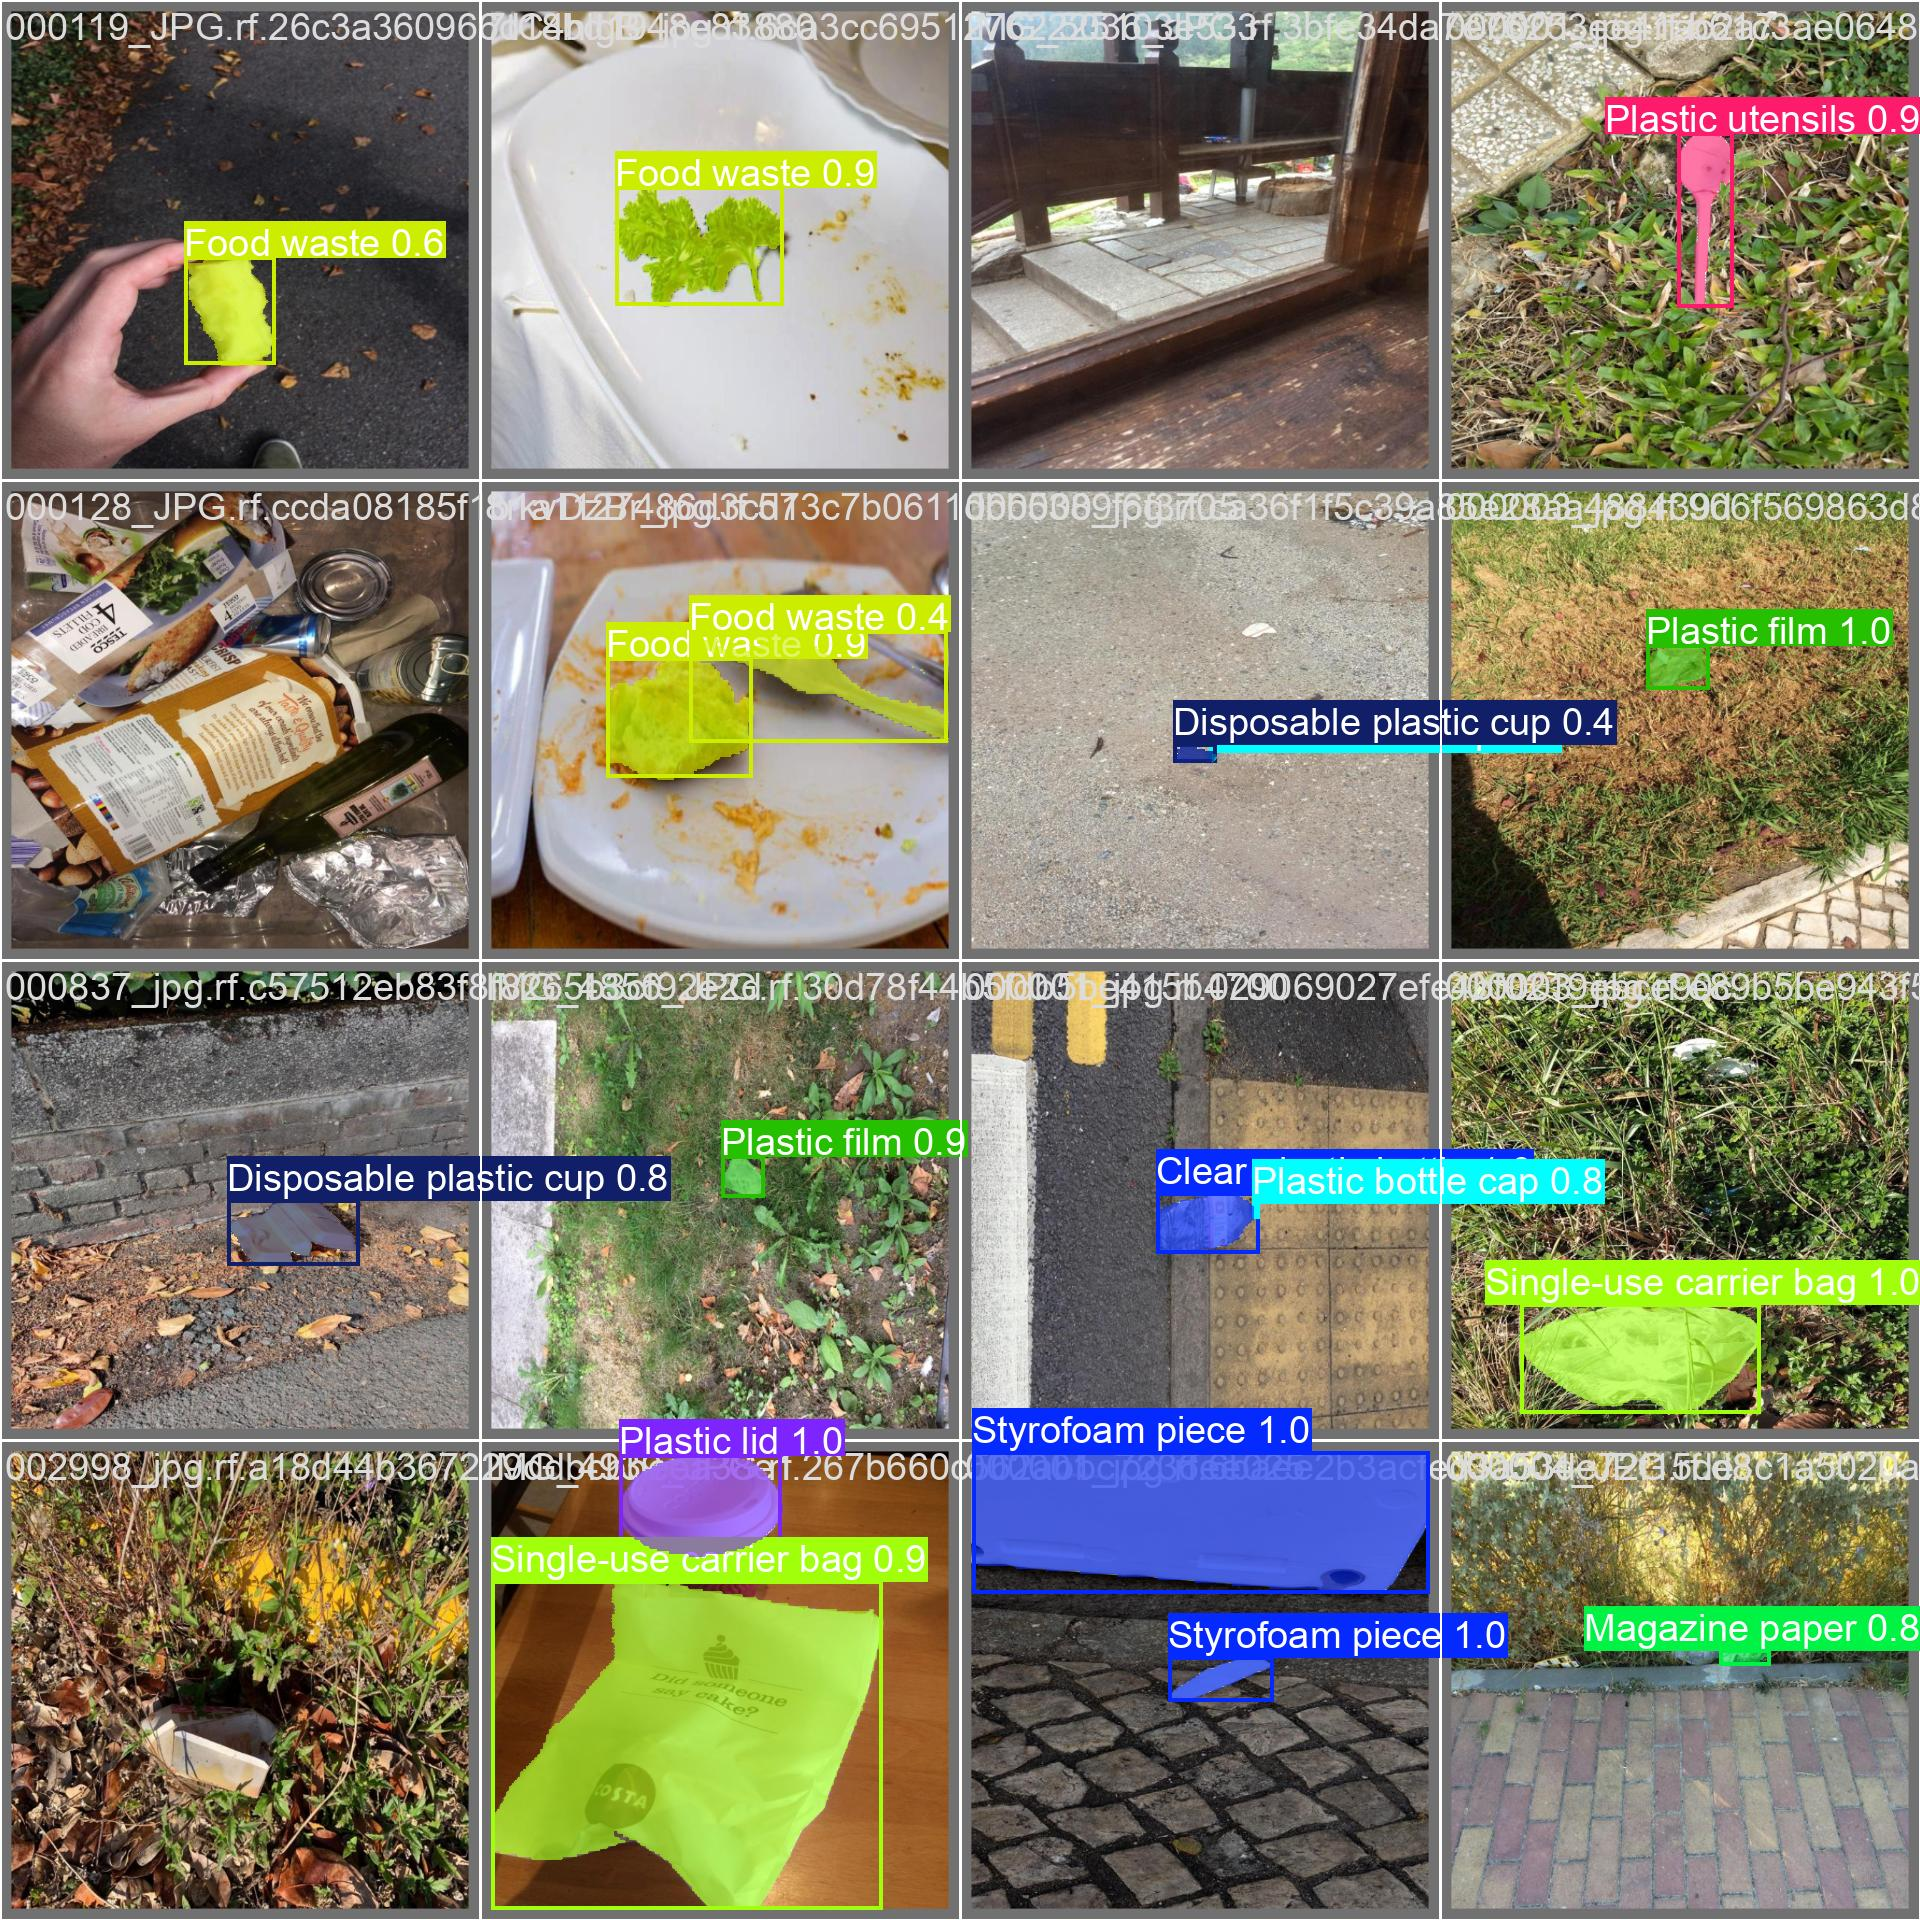

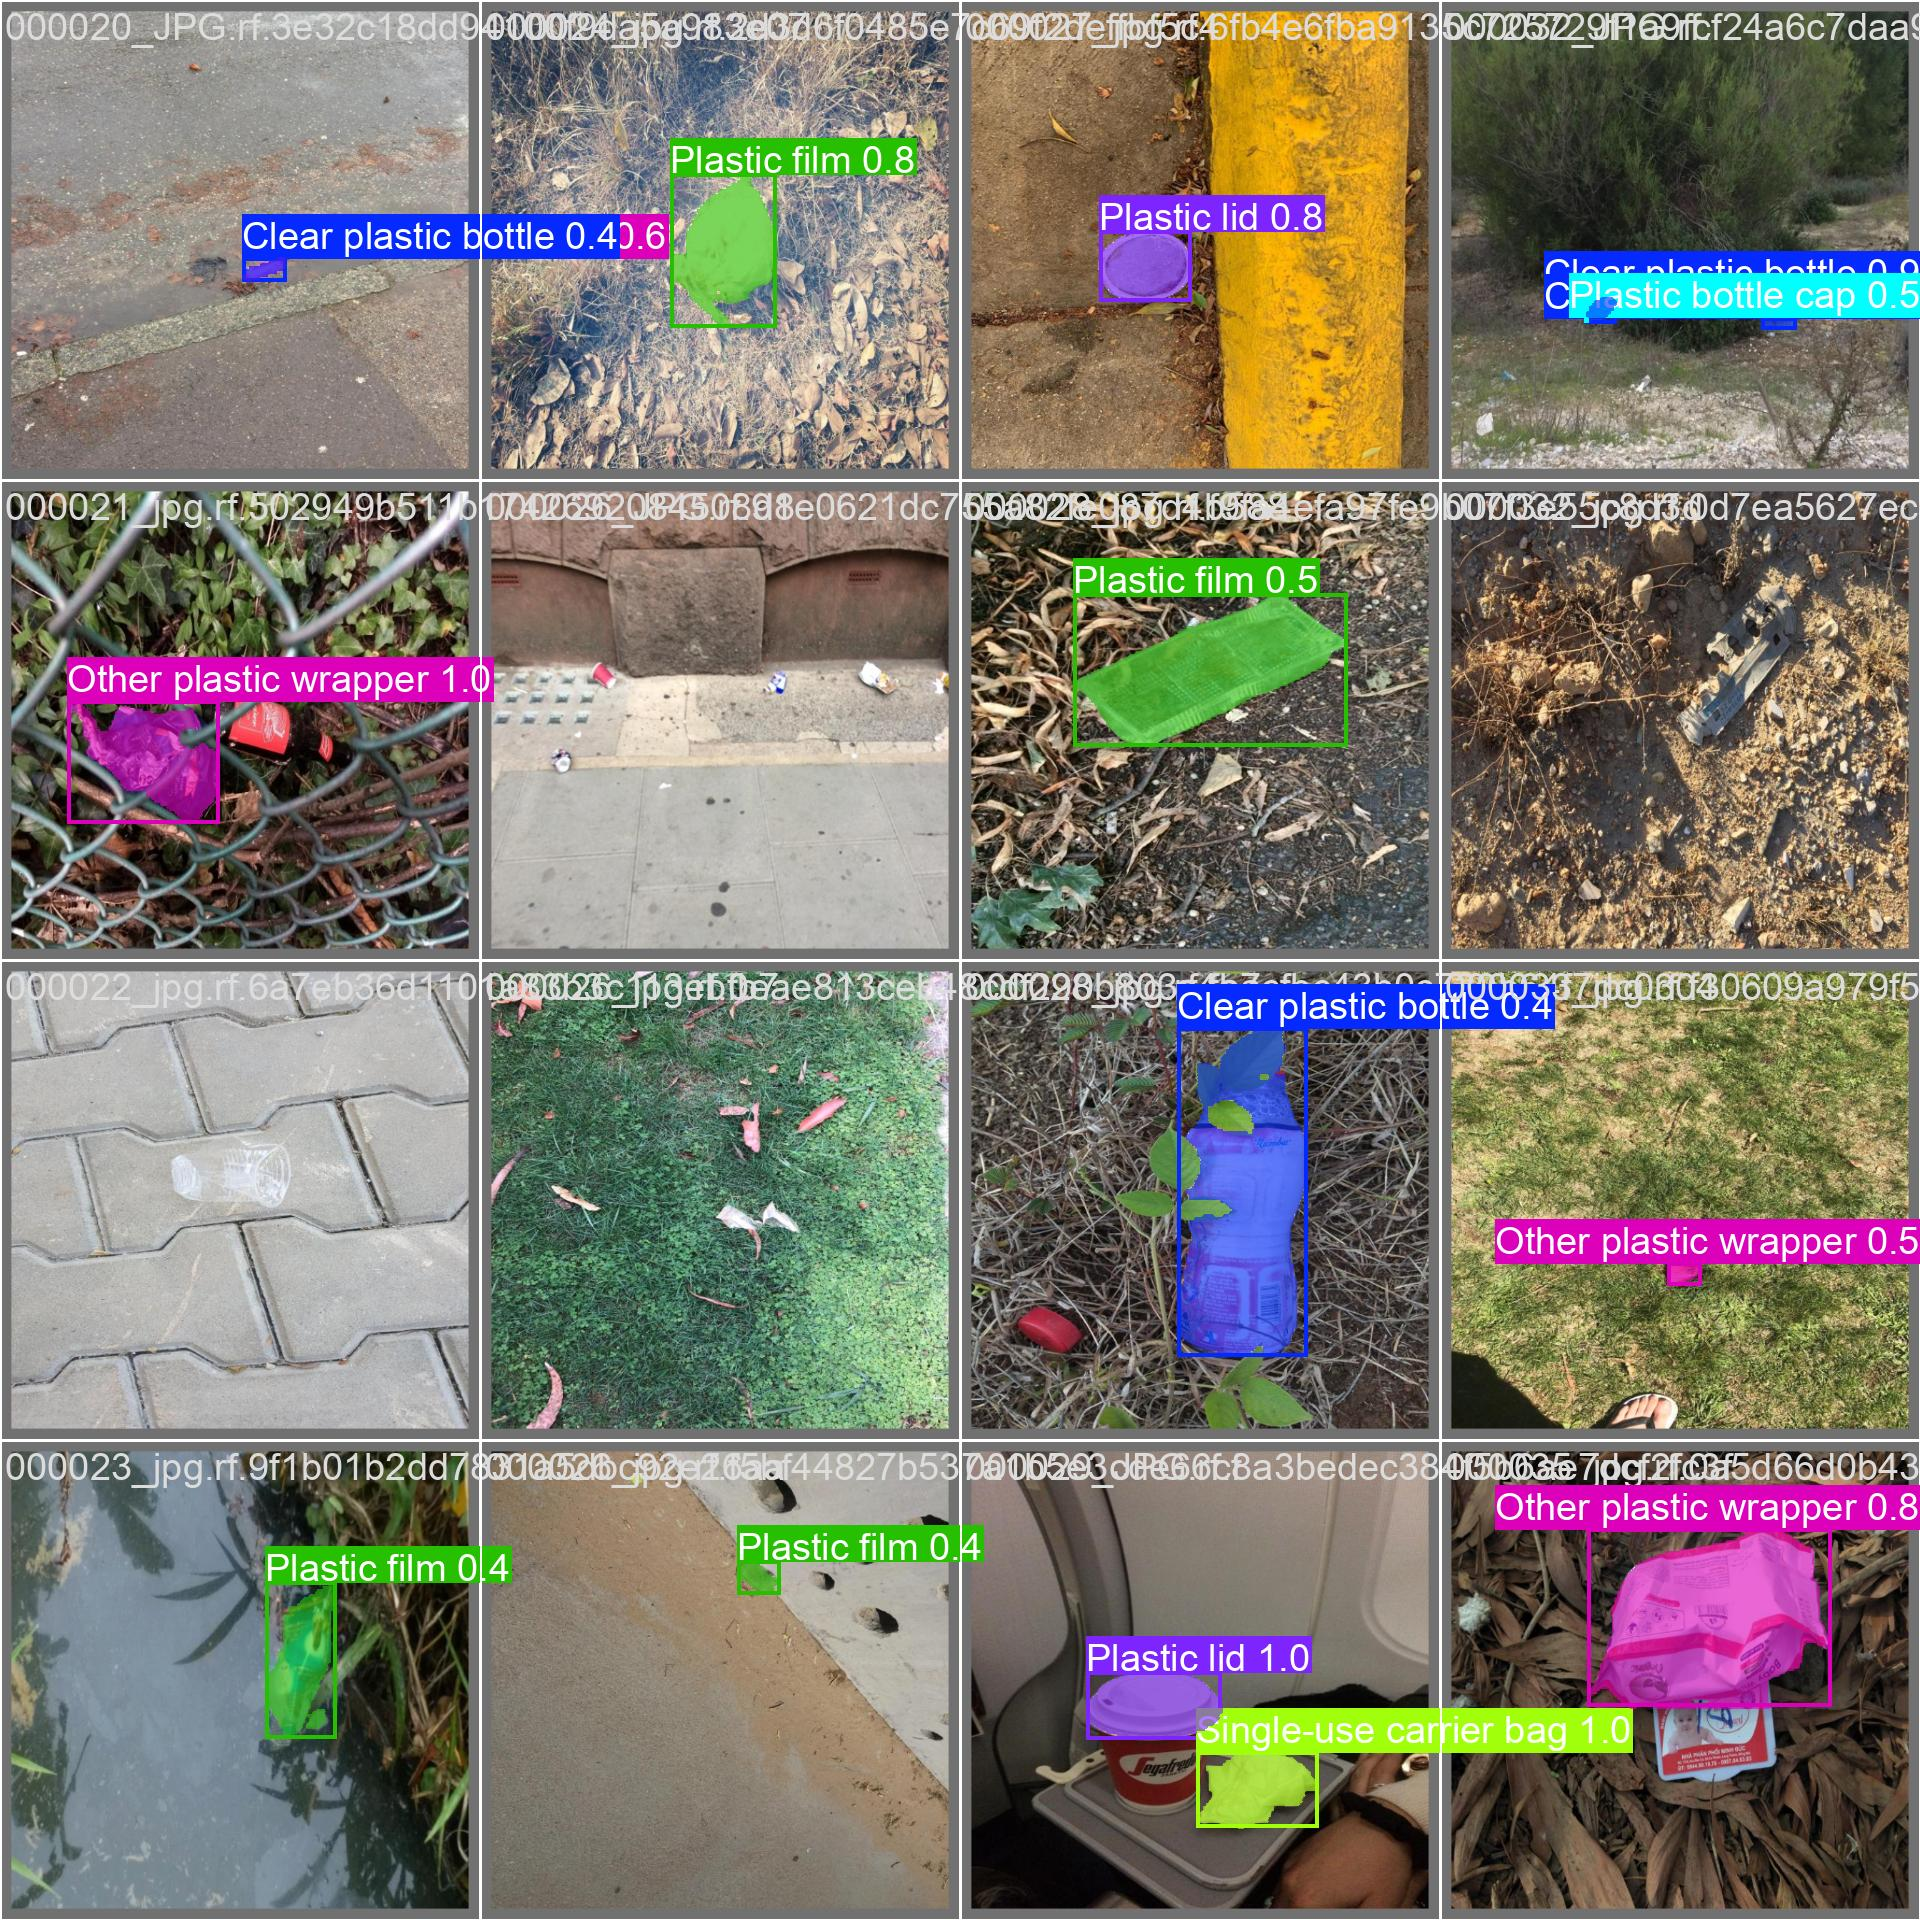

In [21]:
for image_path in glob.glob(f'{HOME}/datasets/runs/segment/train61322/*pred.jpg'):
    display(Image(filename=image_path, height=600))
    print("\n")

In [17]:
ls {HOME}/datasets/runs/segment/train57

args.yaml                                         MaskR_curve.png
BoxF1_curve.png                                   results.csv
BoxP_curve.png                                    results.png
BoxPR_curve.png                                   train_batch0.jpg
BoxR_curve.png                                    train_batch1.jpg
confusion_matrix_normalized.png                   train_batch2.jpg
confusion_matrix.png                              val_batch0_labels.jpg
events.out.tfevents.1734808385.1aac27d513ef.40.4  val_batch0_pred.jpg
labels_correlogram.jpg                            val_batch1_labels.jpg
labels.jpg                                        val_batch1_pred.jpg
MaskF1_curve.png                                  val_batch2_labels.jpg
MaskP_curve.png                                   val_batch2_pred.jpg
MaskPR_curve.png                                  weights/


In [18]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/datasets/runs/segment/train9/")

View the status of your deployment at: https://app.roboflow.com/taco-9911u/taco-trash-annotations-in-context-bumvw/10
Share your model with the world at: https://universe.roboflow.com/taco-9911u/taco-trash-annotations-in-context-bumvw/model/10
